In [37]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma

STARTING_RANGE_PARAMETER = 0.1 # In [fm^-2]
ENDING_RANGE_PARAMETER = 25
REDUCED_MASS = 935 * 10/11 # In [Mev / c^2], need to update value and units (10/11 A in MeV)
SUM_LIMIT = 40 # Determines the number of gaussians we expand our wave function to
CORE_MS_RADIUS = 2.30**2 # In fm^2, taken from p.232 of Tanihata et. al. (2013)

V_LS = 21.0 # In MeV
DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core

CENTRAL_POTENTIAL_PARAMETERS = [0.1, 0.151991, 0.231013, 0.351119, 0.53367, 0.811131, 1.23285,
                                1.87382, 2.84804, 4.32876, 6.57933, 10.]

CENTRAL_MIXING_COEFFICIENTS = [0.0558247,0.214443,2.42773,-0.724055,-2.17761,1.02031,0.819031,-0.96538,0.197094,0.3221,-0.296652,0.093208]

SPIN_ORBIT_POTENTIAL_PARAMETERS = [4.16493, 2.843, 1.941, 1.325, 0.905, 0.618, 0.422, 0.288, 0.196, 0.134, 0.0916, 0.0625]

SPIN_ORBIT_MIXING_COEFFICIENTS = [0.273, -1.307, 3.305, -5.657, 6.565, -3.368, -2.437, 2.638, 0.719, 0.235, 0.0186, 0.00108]


In [38]:
def gaussian_wavefunction(radius, range_parameter, theta, orb_ang_momentum):
    normalisation = (0.5 * (2 * range_parameter * np.exp(2j * theta))**(-1.5 - orb_ang_momentum) * gamma(1.5 + orb_ang_momentum))**(-0.5)
    
    normalisation = (2**(-2.5 - orb_ang_momentum) * (range_parameter)**(3 + 2 * orb_ang_momentum) * gamma(1.5 + orb_ang_momentum))**(-0.5)
    return normalisation * radius**(orb_ang_momentum) * np.exp(- (radius / range_parameter)**2)

def single_gaussian_potential_function(r, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : array like, the radius to evaluate the potential at
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    array like , potential evaluated at r
    """
    return c * np.exp(-β * (r)**2)

def single_gaussian_potential_gradient(r, c, β):
    return c * (-2 * β) * np.exp(-β * (r)**2)

def gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_function(radius, central_mixing_coefficients[i], central_potential_parameters[i])
    return V_0 * potential

def gaussian_expanded_potential_gradient(radius, orb_ang_momentum, mixing_coefficients, potential_parameters):
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_derivative(radius, mixing_coefficients[i], potential_parameters[i])
    return V_0 * potential

def spin_orbit_term(tot_ang_momentum, orb_ang_momentum): # Do we need hbar?
    return 0.5 * (tot_ang_momentum * (tot_ang_momentum + 1) - orb_ang_momentum * (orb_ang_momentum + 1) - 0.75)

def complete_gaussian_potential(radius, tot_ang_momentum, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters,
                                spin_orbit_mixing_coefficients, spin_orbit_potential_parameters, vls=V_LS):
    return gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters
                                      ) - vls * spin_orbit_term(tot_ang_momentum, orb_ang_momentum) * gaussian_expanded_potential_gradient(
        radius, orb_ang_momentum, spin_orbit_mixing_coefficients, spin_orbit_potential_parameters)
        

def complete_woods_saxon_potential(radius, tot_ang_moment, orb_ang_moment, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    R_0 = r_0 * num_core_nucleons**(1/3)
    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)

    return central_potential_term - V_ls * spin_orbit_coupling_term * woods_saxon_derivative

In [39]:
def overlap_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    return ((2 * np.sqrt(range_param_i * range_param_j)) / (range_param_i + range_param_j))**(1.5 + orb_ang_momentum)

def potential_matrix_element(tot_ang_momentum, orb_ang_momentum, range_param_i, range_param_j, central_potential_mixing_coefficient,
                             central_potential_param, spin_orbit_potential_mixing_coefficient, spin_orbit_potential_param, theta, vls=V_LS):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    
    central_potential_term = V_0 * central_potential_mixing_coefficient * ((2 * np.sqrt(range_param_i * range_param_j) * np.exp(-2j * theta)) / (
        (range_param_i + range_param_j) * np.exp(-2j * theta) + central_potential_param))**(1.5 + orb_ang_momentum)
    #central_potential_term = V_0 * central_potential_mixing_coefficient * ((2 * np.sqrt(range_param_i * range_param_j)) / (
    #    range_param_i + range_param_j + central_potential_param))**(1.5 + orb_ang_momentum)

    spin_orbit_potential_term = -2 * spin_orbit_potential_mixing_coefficient * vls * spin_orbit_term(
        tot_ang_momentum, orb_ang_momentum) * spin_orbit_potential_param * ((
        2 * np.sqrt(range_param_i * range_param_j) * np.exp(-2j * theta)) / (
            np.exp(-2j * theta) * (range_param_i + range_param_j) + spin_orbit_potential_param))**(1.5 + orb_ang_momentum)
    #spin_orbit_potential_term = -2 * spin_orbit_potential_mixing_coefficient * vls * spin_orbit_term(
    #    tot_ang_momentum, orb_ang_momentum) * spin_orbit_potential_param * ((
    #    2 * np.sqrt(range_param_i * range_param_j)) / (spin_orbit_potential_param + range_param_i + range_param_j))**(
    #    1.5 + orb_ang_momentum)

    return central_potential_term + spin_orbit_potential_term

def kinetic_matrix_element(orb_ang_momentum, range_param_i, range_param_j, theta, μ=REDUCED_MASS):
    term_1 = 2 * orb_ang_momentum + 3
    term_2 = (range_param_i * range_param_j)**(1.75 + (orb_ang_momentum / 2))
    term_3 = (2 / (range_param_i + range_param_j))**(2.5 + orb_ang_momentum)

    return (197**2 / (2 * μ)) * term_1 * term_2 * term_3 * np.exp(-2j * theta)

In [40]:
def matrix_generation(tot_ang_momentum, orb_ang_momentum, theta, central_mixing_coefficients=CENTRAL_MIXING_COEFFICIENTS,
                      central_potential_parameters=CENTRAL_POTENTIAL_PARAMETERS,
                      spin_orbit_potential_mixing_coefficients=SPIN_ORBIT_MIXING_COEFFICIENTS,
                      spin_orbit_potential_parameters=SPIN_ORBIT_POTENTIAL_PARAMETERS, size=SUM_LIMIT):
    h_matrix = np.zeros(shape=(size, size), dtype=np.complex_)
    n_matrix = np.zeros(shape=(size, size), dtype=np.complex_)
    #h_matrix = np.zeros(shape=(size, size))
    #n_matrix = np.zeros(shape=(size, size))

    for i in range(size):
        i_range_parameter = next_range_parameter(i)
        for j in range(size):
            j_range_parameter = next_range_parameter(j)
            kinetic_energy_term = kinetic_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter, theta)
            potential_energy_term = 0
            for k in range(len(central_mixing_coefficients)):
                potential_energy_term += potential_matrix_element(tot_ang_momentum, orb_ang_momentum, i_range_parameter,
                                                                  j_range_parameter, central_mixing_coefficients[k],
                                                                  central_potential_parameters[k], spin_orbit_potential_mixing_coefficients[k],
                                                                 spin_orbit_potential_parameters[k], theta)
            h_matrix[i, j] = kinetic_energy_term + potential_energy_term
            # h_matrix[j, i] = h_matrix[i, j]
            n_matrix[i, j] = overlap_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            # ((2 * 10**(np.abs(i - j))) / (1 + 10**(2 * np.abs(i - j))))**(1.5 + orb_ang_momentum)
            # n_matrix[j, i] = n_matrix[i, j]
            # j += 1

    return h_matrix, n_matrix


def next_range_parameter(i, starting_range_parameter=STARTING_RANGE_PARAMETER, ending_range_parameter=ENDING_RANGE_PARAMETER,
                         sum_limit=SUM_LIMIT):
    """
    Finds the next range parameter given the previous and initial range parameters.
    Currently using a simple geometric series to determine range parameters.
    Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

    Parameters
    ----------
    i : int detailing the iteration number

    Returns
    -------
    new_range_parameter: float

    """
    geometric_progression_number = (ending_range_parameter / starting_range_parameter)**(1 / (sum_limit - 1))
    new_range_parameter = starting_range_parameter * geometric_progression_number**(i)
    new_range_parameter = 1 / new_range_parameter**2

    return new_range_parameter

theta = 5 * np.pi / 36 
s_h_matrix, s_n_matrix = matrix_generation(0.5, 0, theta)
p_one_half_h_matrix, p_one_half_n_matrix = matrix_generation(0.5, 1, theta)
p_three_half_h_matrix, p_three_half_n_matrix = matrix_generation(1.5, 1, theta)
d_five_half_h_matrix, d_five_half_n_matrix = matrix_generation(2.5, 2, theta)

In [41]:
s_eigenvalues, s_eigenvectors = scipy.linalg.eig(s_h_matrix, s_n_matrix)
s_overlap_eigenvalues, s_overlap_eigenvectors = scipy.linalg.eigh(s_n_matrix)
s_overlap_matrix_condition_number = np.max(s_overlap_eigenvalues) / np.min(s_overlap_eigenvalues)
print(f"The s 1/2 overlap matrix condition number is", s_overlap_matrix_condition_number)

s0_eigenvector = np.asmatrix(s_eigenvectors[:, 0])
s1_eigenvector = np.asmatrix(s_eigenvectors[:, 1])
print("The S state eigenvalues are", s_eigenvalues)
#print("The S1 eigenvector is", s1_eigenvector)
#print(s_eigenvalues[0])

The s 1/2 overlap matrix condition number is 23474779581343.137
The S state eigenvalues are [ 3.40041180e+04-4.05976006e+04j  2.31075672e+04-2.76112865e+04j
  1.64286510e+04-1.96513661e+04j  1.19211656e+04-1.42791974e+04j
  8.74905956e+03-1.04983525e+04j  6.46492712e+03-7.77561288e+03j
  4.79695050e+03-5.78704141e+03j  3.56773306e+03-4.32115257e+03j
  2.65632057e+03-3.23358360e+03j  1.97783755e+03-2.42294893e+03j
  1.47144448e+03-1.81662415e+03j  1.09294378e+03-1.36168852e+03j
  8.10232029e+02-1.01913819e+03j  6.00208270e+02-7.60492353e+02j
  4.45728816e+02-5.65775020e+02j  3.32654501e+02-4.20889562e+02j
  2.48782470e+02-3.14436325e+02j  1.85019717e+02-2.35835737e+02j
  1.36443926e+02-1.76491897e+02j  1.00376136e+02-1.31376206e+02j
  7.38650067e+01-9.76074416e+01j  5.41372191e+01-7.24016543e+01j
  3.95891440e+01-5.34195884e+01j  2.90224004e+01-3.93241848e+01j
 -3.27751113e+01-3.24984516e-06j  2.11906220e+01-2.89580763e+01j
  1.53491137e+01-2.12201745e+01j  1.10873826e+01-1.54165513e+01

In [42]:
p_one_half_eigenvalues, p_one_half_eigenvectors = scipy.linalg.eig(p_one_half_h_matrix, p_one_half_n_matrix)
p_one_half_overlap_eigenvalues, p_one_half_overlap_eigenvectors = scipy.linalg.eigh(p_one_half_n_matrix)
p_one_half_overlap_matrix_condition_number = np.max(p_one_half_overlap_eigenvalues) / np.min(p_one_half_overlap_eigenvalues)
print(f"The P 1/2 overlap matrix condition number is", p_one_half_overlap_matrix_condition_number)

zero_p_one_half_eigenvector = np.asmatrix(p_one_half_eigenvectors[:, 0])
one_p_one_half_eigenvector = np.asmatrix(p_one_half_eigenvectors[:, 1])
print("The P 1/2 state eigenvalues are", p_one_half_eigenvalues)
#print("The 0P1/2 eigenvector is", zero_p_one_half_eigenvector)

The P 1/2 overlap matrix condition number is 1294990422764.1138
The P 1/2 state eigenvalues are [ 3.59812501e+04-4.29228866e+04j  2.45270596e+04-2.92728454e+04j
  1.74801105e+04-2.08749716e+04j  1.27109103e+04-1.51913674e+04j
  9.34720584e+03-1.11824718e+04j  6.92082045e+03-8.29038077e+03j
  5.14640736e+03-6.17516984e+03j  3.83713819e+03-4.61426003e+03j
  2.86527870e+03-3.45524317e+03j  2.14107849e+03-2.59080638e+03j
  1.60015068e+03-1.94407675e+03j  1.19546160e+03-1.45913934e+03j
  8.92501234e+02-1.09464585e+03j  6.66224049e+02-8.20126875e+02j
  4.98036819e+02-6.13704372e+02j  3.72942109e+02-4.59516196e+02j
  2.79161285e+02-3.44313146e+02j  2.09028242e+02-2.58110861e+02j
  1.56160048e+02-1.93987623e+02j  1.15813394e+02-1.45534558e+02j
  8.58879175e+01-1.08457922e+02j  6.40314489e+01-8.08194082e+01j
  4.75806589e+01-6.03993510e+01j  3.51403602e+01-4.49524727e+01j
  2.60245585e+01-3.32902114e+01j  1.92993317e+01-2.46888564e+01j
  1.42145113e+01-1.83083065e+01j  1.03931026e+01-1.34948247

In [43]:
p_three_half_eigenvalues, p_three_half_eigenvectors = scipy.linalg.eig(p_three_half_h_matrix, p_three_half_n_matrix)
p_three_half_overlap_eigenvalues, p_three_half_overlap_eigenvectors = scipy.linalg.eigh(p_three_half_n_matrix)
p_three_half_overlap_matrix_condition_number = np.max(p_three_half_overlap_eigenvalues) / np.min(p_three_half_overlap_eigenvalues)
print(f"The P 3/2 overlap matrix condition number is", p_three_half_overlap_matrix_condition_number)

zero_p_three_half_eigenvector = np.asmatrix(p_three_half_eigenvectors[:, 0])
one_p_three_half_eigenvector = np.asmatrix(p_three_half_eigenvectors[:, 1])
print("The P 3/2 state eigenvalues are", p_three_half_eigenvalues)
#print("The 0P3/2 eigenvector is", zero_p_three_half_eigenvector)

The P 3/2 overlap matrix condition number is 1294990422764.1138
The P 3/2 state eigenvalues are [ 3.59753598e+04-4.29223852e+04j  2.45218301e+04-2.92720504e+04j
  1.74754938e+04-2.08741068e+04j  1.27067984e+04-1.51906223e+04j
  9.34341707e+03-1.11819660e+04j  6.91715294e+03-8.29011545e+03j
  5.14274037e+03-6.17503970e+03j  3.83349486e+03-4.61416905e+03j
  2.86173562e+03-3.45524444e+03j  2.13755897e+03-2.59106614e+03j
  1.59638328e+03-1.94461491e+03j  1.19126248e+03-1.45969671e+03j
  8.87964268e+02-1.09495567e+03j  6.61447266e+02-8.20064128e+02j
  4.93063801e+02-6.12912228e+02j  3.68667736e+02-4.57487866e+02j
  2.76598329e+02-3.42244221e+02j  2.07022873e+02-2.57070249e+02j
  1.53955481e+02-1.93035279e+02j  1.14156935e+02-1.44384393e+02j
  8.46808177e+01-1.07744785e+02j  6.27638446e+01-8.03288167e+01j
  4.64037569e+01-5.97976868e+01j  3.42251010e+01-4.43237996e+01j
  2.53466685e+01-3.27124136e+01j  1.88266432e+01-2.42119037e+01j
  1.38708425e+01-1.79450487e+01j  1.01344095e+01-1.32245162

In [44]:
d_five_half_eigenvalues, d_five_half_eigenvectors = scipy.linalg.eig(d_five_half_h_matrix, d_five_half_n_matrix)
d_five_half_overlap_eigenvalues, d_five_half_overlap_eigenvectors = scipy.linalg.eigh(d_five_half_n_matrix)
d_five_half_overlap_matrix_condition_number = np.max(d_five_half_overlap_eigenvalues) / np.min(d_five_half_overlap_eigenvalues)
print(f"The D 5/2 overlap matrix condition number is", d_five_half_overlap_matrix_condition_number)

zero_d_five_half_eigenvector = np.asmatrix(d_five_half_eigenvectors[:, 0])
one_d_five_half_eigenvector = np.asmatrix(d_five_half_eigenvectors[:, 1])
print("The D 5/2 state eigenvalues are", d_five_half_eigenvalues)
#print("The 0D5/2 eigenvector is", zero_d_five_half_eigenvector)
#print(d_five_half_eigenvalues[33])
#print(d_five_half_eigenvalues[34])
#print(d_five_half_eigenvalues[35])
#print(d_five_half_eigenvalues[33:36])

The D 5/2 overlap matrix condition number is 128692128724.63907
The D 5/2 state eigenvalues are [3.79508446e+04-4.53054714e+04j 2.59312714e+04-3.09800974e+04j
 1.85095389e+04-2.21344076e+04j 1.34729796e+04-1.61314070e+04j
 9.91296374e+03-1.18881916e+04j 7.34036565e+03-8.82176589e+03j
 5.45627844e+03-6.57578595e+03j 4.06454846e+03-4.91632864e+03j
 3.03067988e+03-3.68296291e+03j 2.25973415e+03-2.76248826e+03j
 1.68333738e+03-2.07337818e+03j 1.25172578e+03-1.55595659e+03j
 9.28655199e+02-1.16620384e+03j 6.87684074e+02-8.71738879e+02j
 5.09531475e+02-6.49049371e+02j 3.79442358e+02-4.81981744e+02j
 2.84239857e+02-3.58804509e+02j 2.12748091e+02-2.68829951e+02j
 1.57596926e+02-2.01823075e+02j 1.16026370e+02-1.50371333e+02j
 8.58558082e+01-1.11565028e+02j 6.35307636e+01-8.28919453e+01j
 4.68428418e+01-6.13589363e+01j 3.46961834e+01-4.51544538e+01j
 2.59627159e+01-3.32741014e+01j 1.93917228e+01-2.47439524e+01j
 1.42911753e+01-1.83675733e+01j 1.04982738e+01-1.35270041e+01j
 7.70114876e+00-9.9023

In [52]:
theta_values = np.linspace(0, 0.15, 40)
d_five_halfs_eigenvalue_theta_matrix = np.zeros(shape=(len(theta_values), SUM_LIMIT), dtype=np.complex_)
for i in enumerate(theta_values):
    d_five_half_h_matrix, d_five_half_n_matrix = matrix_generation(2.5, 2, i[1])
    d_five_half_eigenvalues, d_five_half_eigenvectors = scipy.linalg.eig(d_five_half_h_matrix, d_five_half_n_matrix)
    d_five_halfs_eigenvalue_theta_matrix[i[0], :] = d_five_half_eigenvalues

s_half_eigenvalue_theta_matrix = np.zeros(shape=(len(theta_values), SUM_LIMIT), dtype=np.complex_)
for i in enumerate(theta_values):
    s_h_matrix, s_n_matrix = matrix_generation(0.5, 0, i[1])
    s_eigenvalues, s_eigenvectors = scipy.linalg.eig(s_h_matrix, s_n_matrix)
    s_half_eigenvalue_theta_matrix[i[0], :] = s_eigenvalues


print(d_five_halfs_eigenvalue_theta_matrix[0, :10])


#print(d_five_halfs_eigenvalue_theta_matrix)
#print(s_half_eigenvalue_theta_matrix)

[59077.51048265-1.35003383e-09j 40378.07276067-9.61182158e-10j
 28831.57286532-5.69107650e-10j 20995.78806618-3.60296253e-10j
 15457.19718718-1.72876494e-10j 11454.88120594-1.11748151e-10j
  8523.81200062-1.75526029e-10j  6358.77172983-2.35829501e-10j
  4750.44304505-2.83730756e-10j  3551.13348458-1.50030572e-10j]


In [53]:
print(d_five_halfs_eigenvalue_theta_matrix[0, 30:])
print(d_five_halfs_eigenvalue_theta_matrix[1, 30:])
print(d_five_halfs_eigenvalue_theta_matrix[2, 30:])
print(d_five_halfs_eigenvalue_theta_matrix[3, 30:])

[6.70006313+1.49717356e-08j 4.82949993+1.71195744e-08j
 3.43835767+1.17488077e-08j 2.4063061 +3.88786376e-09j
 1.65755639+4.73241837e-09j 1.2818671 +1.63026109e-09j
 0.99884466+5.05896101e-09j 0.61140544+8.03605906e-09j
 0.3214057 +7.88750179e-09j 0.12566098+3.97486255e-09j]
[6.69984814-0.05316428j 4.82934616-0.03809283j 3.4382491 -0.02690083j
 2.4062296 -0.01853276j 1.65748565-0.011653j   1.28185627-0.00312096j
 0.99884487-0.00674887j 0.61138865-0.0046437j  0.32139629-0.00246713j
 0.12565727-0.00096636j]
[6.6992031 -0.10632503j 4.82888481-0.07618313j 3.43792333-0.05379989j
 2.4060001 -0.03706445j 1.65727349-0.02330756j 1.28182383-0.00623545j
 0.99884541-0.01350099j 0.61133828-0.00928721j 0.32136806-0.00493411j
 0.12564613-0.00193266j]
[6.69812814-0.15947877j 4.82811598-0.11426841j 3.43738044-0.08069546j
 2.40561763-0.05559397j 1.65692016-0.03496527j 1.28176989-0.00933701j
 0.99884593-0.02025962j 0.61125433-0.01393038j 0.32132101-0.00740082j
 0.12562756-0.00289885j]


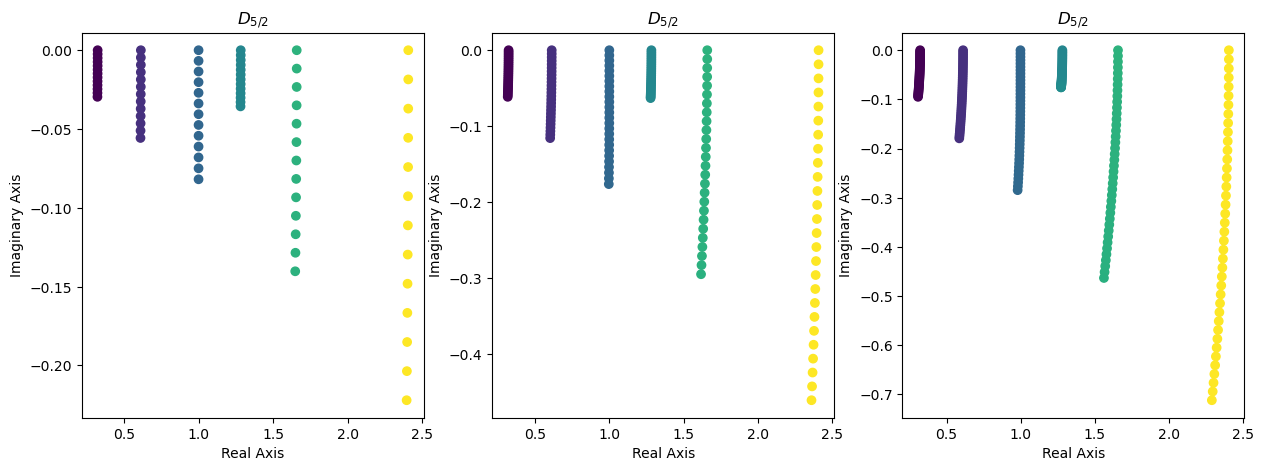

In [72]:
fig = plt.figure(figsize=(15, 5))
spec = fig.add_gridspec(ncols=3, nrows=1)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])
ax_3 = fig.add_subplot(spec[0, 2])

theta_values_parital_1 = np.linspace(0, 0.5, 13)
theta_values_parital_2 = np.linspace(0, 0.10, 26)

for i in enumerate(theta_values_parital_1):
    ax_1.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]),
               np.imag(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), c=(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), cmap='viridis')
ax_1.set_xlabel('Real Axis')
ax_1.set_ylabel('Imaginary Axis')
ax_1.set_title(r'$D_{5/2}$')

for i in enumerate(theta_values_parital_2):
    ax_2.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]),
               np.imag(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), c=(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), cmap='viridis')
ax_2.set_xlabel('Real Axis')
ax_2.set_ylabel('Imaginary Axis')
ax_2.set_title(r'$D_{5/2}$')

for i in enumerate(theta_values):
    ax_3.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]),
               np.imag(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), c=(d_five_halfs_eigenvalue_theta_matrix[i[0], 33:39]), cmap='viridis')
# ax_3.scatter(np.real(d_five_halfs_eigenvalue_theta_matrix[39, 35]), np.imag(d_five_halfs_eigenvalue_theta_matrix[39, 35]), c='r')
ax_3.set_xlabel('Real Axis')
ax_3.set_ylabel('Imaginary Axis')
ax_3.set_title(r'$D_{5/2}$')

plt.savefig('D_five_half_resonace.png')
plt.show()

In [68]:
print(d_five_halfs_eigenvalue_theta_matrix[39, 35])
print(d_five_halfs_eigenvalue_theta_matrix[0, 35])

(1.272940916051256-0.0756956761952816j)
(1.2818671014449288+1.6302610900217704e-09j)
